In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.transforms
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import simpson

import csv
from csv import writer

import os
import statistics



Ну короче эта типа возникновение рамановского излучения в волокне

Гипотеза 1: чем больше мощность тем больше раман (посмотреть зависимость)

Гипотеза 2: температура высвета коррелирует с шириной спектра??? афигеть просто

Имеется файл с данными о зависимости выходной мощности и температуры высвета (фрагмента волокна, покрытого высвечивающим полимером) от процента тока накачки относительно максимального. Давайте считаем эти данные и построим эти зависимости.

Из графика видно, что зависимость выходной мощности не совесм линейная при маленбких значениях тока, поэтому воспользуемся функцией линейной интерполяции.

78.0


C:\Users\vika\AppData\Local\Temp\ipykernel_4872\3648297997.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(I, y, 'ro', marker = 'o', markersize = 2)


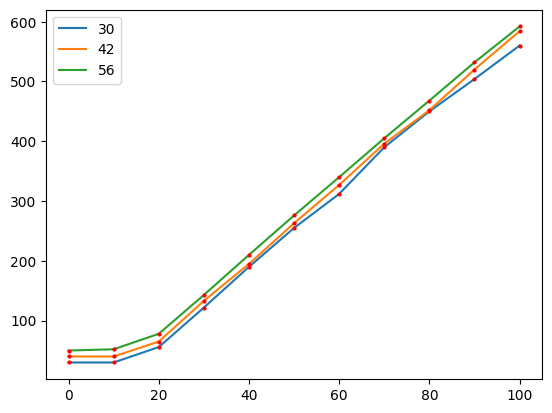

In [3]:

# Считываем файл
Pout_data = pd.read_csv('Pout_data.dat', sep = '\t')
I = Pout_data.iloc[:, 0]

Powers =['30', '42', '56']
Power_lambdas= dict.fromkeys(Powers) 

def get_power(P_nom, Iproc ):
    return Power_lambdas[P_nom](Iproc)
 
fig, ax = plt.subplots()
for power in Powers:
    y = [float(a.replace(',', '.')) for a in Pout_data['Pout' + power]]
    p = lambda i: np.interp(i, I, y) 
    Power_lambdas[power] = p

    x = np.linspace(0, 100, 101)
    plt.plot(x, get_power(power, x),  label = power)
    plt.plot(I, y, 'ro', marker = 'o', markersize = 2)
       
plt.legend()
    
    
    
print(get_power('56', 20) )

In [77]:

def read_spectrum(f:str):
    Pnom = f.split('//')[-1].split('.')[0].split('-')[0]
    Iproc = f.split('//')[-1].split('.')[0].split('-')[1]
    Pout = get_power(Pnom, float(Iproc))

    colnames = ['nm', 'dBm']
    scan = pd.read_csv(f, skiprows = 29, names=colnames)

    lmbdas = scan['nm']
    # value = 10**(scan['dBm']/10)
    value = scan['dBm']
    return {'Pout': Pout, 
            'lmbdas' :lmbdas,
            'value': value}

path = '600//'

dict_template = {'data':[] }

non_raman = {'30': {'data':[] }, 
             '42': {'data':[] }, 
             '56': {'data':[] }}

raman = {'56': {'data':[] }}


for name in os.listdir(path):
    f = os.path.join(path, name)
    # print(f, os.path.isfile(f), name[-4:])
    if os.path.isfile(f) and name[-4:] == '.CSV':

        spectrum = read_spectrum(f)
        split = name.split('.')[0].split('-')

        if len(split) == 2:
            non_raman[split[0]]['data'].append(spectrum)
            # print(len(non_raman[split[0]]['data']))

        elif len(split) == 3:
            raman[split[0]]['data'].append(spectrum)
            # print(len(raman[split[0]]['data']))


(1072.2967, 1.0566999999998643, -27.021, 0.8441467987333563)

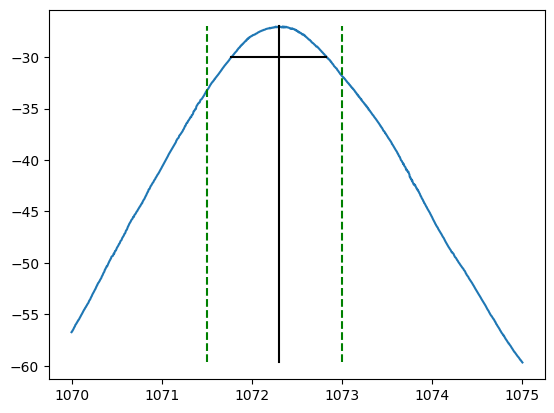

In [78]:
# print(raman)
# plt.plot(non_raman['30']['data'][0]['lmbdas'], non_raman['30']['data'][0]['value'] )

def analyze_spectrum(spectrum, lmbda_1, lmbda_2, out = 0):
    lmbdas = spectrum['lmbdas']
    value = spectrum['value']
    i_value = 10**(spectrum['value']/10)
    idx1 = np.where(lmbdas == lmbda_1)[0][0]
    idx2 = np.where(lmbdas == lmbda_2)[0][0]

    all_power = simpson(i_value, x = lmbdas)
    peak_power = simpson(i_value[idx1:idx2], x = lmbdas[idx1:idx2])
    power_share = peak_power/all_power
    
    power_peak = max(value[idx1:idx2])
    central_lmbda = lmbdas[np.where(value == power_peak)[0][0]]

    left = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][0]]
    right = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][-1]]
    width = right - left

    if out == 1:
        plt.plot(lmbdas, value)
        plt.plot([lmbda_1, lmbda_1], [min(value), power_peak], 'g--')
        plt.plot([lmbda_2, lmbda_2], [min(value), power_peak], 'g--')

        plt.plot([central_lmbda, central_lmbda], [min(value), power_peak], color = 'black')
        plt.plot([central_lmbda - width/2, central_lmbda + width/2], [power_peak-3, power_peak-3], color = 'black')  

    return central_lmbda, width, power_peak, power_share


analyze_spectrum(non_raman['56']['data'][-1], 1071.5, 1073, 1)

532.0


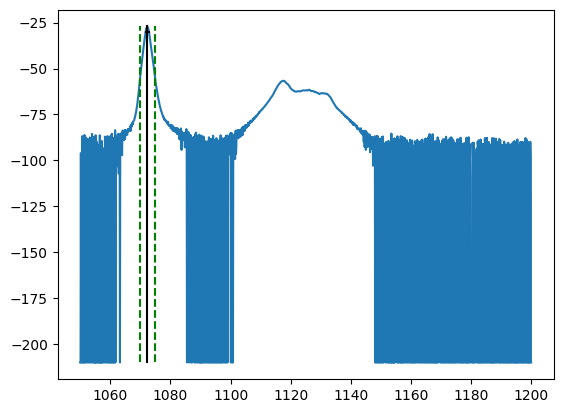

In [87]:
analyze_spectrum(raman['56']['data'][11], 1070, 1075, 1)
print(raman['56']['data'][11]['Pout'])
# plt.plot((raman['56']['data'][-1])['lmbdas'], 10**((raman['56']['data'][-1]['value'])/10))
# plt.xlim(1100, 1150)